In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
#python -m spacy download en_core_web_sm
#python -m spacy download en_core_web_md
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
from sklearn.datasets import fetch_20newsgroups

import pickle
import bz2
import time
import logging
import os



C:\Users\jorda\anaconda3\envs\WH\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jorda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Bug fix for pyLDAvis https://github.com/bmabey/pyLDAvis/issues/162
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))

# Load datapickle 
From wikidownloader.py

In [3]:
print('Load data pickle')
with bz2.BZ2File('datapicklesoup.bz2', 'rb') as f:  #Use datacompression BZ2
    data= pickle.load(f)
print('Loaded data pickle')
    
df=pd.DataFrame({'text':data[0],'title':data[1]})

Load data pickle
Loaded data pickle


In [4]:
df

,text,title
0,Megacraspedus cuencellus is a moth of the fami...,Megacraspedus_cuencellus
1,Jellyfish dermatitis is a cutaneous condition ...,Jellyfish_dermatitis
2,The Hadrianic Society was a British historical...,Hadrianic_Society
3,The CPL–U Sports Draft (French: Repêchage de l...,CPL%E2%80%93U_Sports_Draft
4,Mikhail Ivanovich Meltyukhov (Russian: Russian...,Mikhail_Meltyukhov
...,...,...
49884,Swertia perennis is a species of flowering pla...,Swertia_perennis
49885,Sarah Johns (born 1979) is an American country...,Sarah_Johns
49886,Abū Thābit Sulaymān ibn Saʿd al-Khūshani (Arab...,Sulayman_ibn_Sa%27d_al-Khushani
49887,Argyresthia pilatella is a moth of the family ...,Argyresthia_pilatella


In [5]:
#remove zero length articles
articlelen=df.text.apply(len)
df=df[articlelen>10]

# Tokenizing articles


In [6]:
def sent_to_words(sentences):
   for sentence in sentences:
      yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
data_words = list(sent_to_words(df.text))

In [7]:
print(df.text[0][:400])

Megacraspedus cuencellus is a moth of the family Gelechiidae. It was described by Aristide Caradja in 1920. It is found in France and Spain. The forewings are uniform mouse grey with the margin whitish from one-third to the apex. The hindwings are mouse grey. 


In [8]:
print(data_words[0][:40])

['megacraspedus', 'cuencellus', 'is', 'moth', 'of', 'the', 'family', 'gelechiidae', 'it', 'was', 'described', 'by', 'aristide', 'caradja', 'in', 'it', 'is', 'found', 'in', 'france', 'and', 'spain', 'the', 'forewings', 'are', 'uniform', 'mouse', 'grey', 'with', 'the', 'margin', 'whitish', 'from', 'one', 'third', 'to', 'the', 'apex', 'the', 'hindwings']


In [9]:
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]
print([(id2word[id], freq) for id, freq in corpus[0]][:20])
print(corpus[0][:20]) #it will print the corpus we created above.



[('and', 1), ('apex', 1), ('are', 2), ('aristide', 1), ('by', 1), ('caradja', 1), ('cuencellus', 1), ('described', 1), ('family', 1), ('forewings', 1), ('found', 1), ('france', 1), ('from', 1), ('gelechiidae', 1), ('grey', 2), ('hindwings', 1), ('in', 2), ('is', 2), ('it', 2), ('margin', 1)]
[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 2), (17, 2), (18, 2), (19, 1)]


# Removing stop words and adding bigrams

In [10]:

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
def remove_stopwords(texts):
   return [[word for word in simple_preprocess(str(doc)) 
   if word not in stop_words] for doc in texts]
def make_bigrams(texts):
   return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
   return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)


In [11]:
print(data_words_nostops[0][:40])

['megacraspedus', 'cuencellus', 'moth', 'family', 'gelechiidae', 'described', 'aristide', 'caradja', 'found', 'france', 'spain', 'forewings', 'uniform', 'mouse', 'grey', 'margin', 'whitish', 'one', 'third', 'apex', 'hindwings', 'mouse', 'grey']


In [12]:
print(data_words_bigrams[0][:40])

['megacraspedus', 'cuencellus', 'moth', 'family_gelechiidae', 'described', 'aristide', 'caradja', 'found', 'france', 'spain', 'forewings', 'uniform', 'mouse', 'grey', 'margin', 'whitish', 'one', 'third', 'apex', 'hindwings', 'mouse', 'grey']


# Lemmatization

Reference: https://www.researchgate.net/publication/341574872_Machine_Learning_and_Deep_Neural_Network-Based_Lemmatization_and_Morphosyntactic_Tagging_for_Serbian


The basic set of PoS-categories/tags that should be as-signed to tokens is not generally accepted, even for a speciﬁc language. The choice of a tagset usually depends on the foreseen task or project. A tagset tailored to be applicable for PoS-tagging in general is the Universal Part-of-Speech (UPoS) tagset (Petrov et al., 2012) (used by spaCy), and it lists the following 17 categories: adjective(ADJ), adposition (ADP), adverb (ADV), auxiliary (AUX),coordinating conjunction (CCONJ), determiner (DET), interjection (INTJ), noun (N), numerical (NUM), particle(PART), pronoun (PRON), proper noun (PROPN), punctuation (PUNCT), subordinating conjunction (SCONJ), symbol (SYM), verb (VERB) and other (X). It should be notedthat the MULTEXT-East tagset (Erjavec, 2012) was alsotailored to be universal. SMD uses its own tagset thatcorresponds closely to Serbian traditional grammars. TheSerbian TreeTagger models TT11 and TT19 (see Subsec-tion 3.3.) use modiﬁcations of the SMD tagset. A gen-eral overview of the tagsets used is presented in Table 3.It should be noted that tags for some PoS differ betweentagsets (e.g. ADJ in UPoS vs. A in SMD for adjective

In [13]:
doc=nlp(" ".join(data_words_bigrams[0]))

In [14]:
tags=[]
for w in doc:
    if not w.pos_ in tags:
        print('Lemmatization Example {} -> {}'.format(w.lemma_,w.pos_))
        tags.append(w.pos_)
tags

Lemmatization Example megacraspedus -> PROPN
Lemmatization Example moth -> NOUN
Lemmatization Example describe -> VERB
Lemmatization Example whitish -> ADJ
Lemmatization Example one -> NUM


['PROPN', 'NOUN', 'VERB', 'ADJ', 'NUM']

We will only keep the UPoS with the following tags 'NOUN', 'ADJ', 'VERB', 'ADV'

In [15]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
   texts_out = []
   for sent in texts:
      doc = nlp(" ".join(sent))
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
   return texts_out

def lemmatization2(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
   texts_out = []
   for sent in texts:
      doc = nlp(sent)
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
   return texts_out


In [16]:
#bigrams, then lemmatize, then remove stop words
data_lemmatized = make_bigrams(data_words)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_lemmatized, allowed_postags=[
   'NOUN', 'ADJ', 'VERB', 'ADV'
])
data_lemmatized = remove_stopwords(data_lemmatized)


In [17]:
print(data_lemmatized[0][:40]) #it will print the lemmatized data.

['describe', 'find', 'forewing', 'uniform', 'mouse', 'grey', 'margin', 'whitish', 'third', 'apex', 'hindwing', 'mouse', 'grey']


In [18]:
print(data_words_bigrams[0][:55])

['megacraspedus', 'cuencellus', 'moth', 'family_gelechiidae', 'described', 'aristide', 'caradja', 'found', 'france', 'spain', 'forewings', 'uniform', 'mouse', 'grey', 'margin', 'whitish', 'one', 'third', 'apex', 'hindwings', 'mouse', 'grey']


# Creating bag of words frequencies

Without Lemmatization

In [19]:
id2word = corpora.Dictionary(data_words_bigrams)
texts = data_words_bigrams
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[0][:20]) #it will print the corpus we created above.
[(id2word[id], freq) for id, freq in corpus[0]][:20]
#it will print the words with their frequencies.


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]


[('apex', 1),
 ('aristide', 1),
 ('caradja', 1),
 ('cuencellus', 1),
 ('described', 1),
 ('family_gelechiidae', 1),
 ('forewings', 1),
 ('found', 1),
 ('france', 1),
 ('grey', 2),
 ('hindwings', 1),
 ('margin', 1),
 ('megacraspedus', 1),
 ('moth', 1),
 ('mouse', 2),
 ('one', 1),
 ('spain', 1),
 ('third', 1),
 ('uniform', 1),
 ('whitish', 1)]

In [20]:
print(f'Number of unique tokens: {len(id2word)}')
print(f'Number of documents: {len(corpus)}')

Number of unique tokens: 380536
Number of documents: 49835


With Lemmatization

In [52]:
id2word_lemmatized = corpora.Dictionary(data_lemmatized)

# Filter out words that occur less than X documents, 
# or more than X% of the documents.
id2word_lemmatized.filter_extremes(no_below=10, no_above=0.1)

corpus_lemmatized = [id2word_lemmatized.doc2bow(text) for text in data_lemmatized]
print(corpus_lemmatized[0][:20]) #it will print the corpus we created above.
[(id2word_lemmatized[id], freq) for id, freq in corpus_lemmatized[0]][:20]
#it will print the words with their frequencies.


[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1)]


[('apex', 1),
 ('describe', 1),
 ('forewing', 1),
 ('grey', 2),
 ('hindwing', 1),
 ('margin', 1),
 ('mouse', 2),
 ('third', 1),
 ('uniform', 1),
 ('whitish', 1)]

In [22]:
print(f'Number of unique tokens: {len(id2word_lemmatized)}')
print(f'Number of documents: {len(corpus_lemmatized)}')

Number of unique tokens: 26262
Number of documents: 49835


In [23]:
dictwords=set(id2word_lemmatized.values())

In [24]:
data_lemmatized_filtered=[[w for w in article if w in dictwords] for article in data_lemmatized]

# Fitting via LDA Variational Inference (Gensim) library

About Gensim algorithmn

The core estimation code is based on the `onlineldavb.py script

    https://github.com/blei-lab/onlineldavb/blob/master/onlineldavb.py
    Matthew D. Hoffman, David M. Blei, Francis Bach:
    
Online Learning for Latent Dirichlet Allocation', NIPS 2010

    Hoffman et al.: online-lda_
    https://papers.neurips.cc/paper/2010/file/71f6278d140af599e06ad9bf1ba03cb0-Paper.pdf


![LDA ALGO](https://github.com/duha-aldebakel/DSC180B-LDACode/blob/master/images/VB_LDA.PNG?raw=true)

![LDA ALGO](https://github.com/duha-aldebakel/DSC180B-LDACode/blob/master/images/VB_LDA_Algo1.PNG?raw=true)

EM Algorihmn explanation:

Given the statistical model which generates a set w  of observed data (corpus), a set of unobserved latent data beta and theta, and a vector of unknown parameters lambda, along with a likelihood function

    First, initialize the parameters lambda to some random values.
    E: Compute the probability of each possible value of beta and theta, given lambda λ
    M: Use the just-computed probability disribution of beta and theta to compute a better estimate for the parameters lambda
    Iterate E-step 2 and M-step 3 until convergence.

E step: 

    fits phi φ(per word topic assignment) and gamma γ (topic assignment for document k)
    note phi φ is the associated variational parameter of z

    for every document
      hillclimb until peak
        phi φ (per word topic assignment) 
        word w in document d is likely part of topic k if 
          theta, the topic distribution for that document d is high for k
          plus
          beta, the word w is often associated with topic k
        gamma γ (topic assignment for document k)
          has its distribution by taking into account 
          phi (per word topic assignment)  times n
          n is the frequency word w appears in document d. 
      
M step:

    fits lambda λ, the distribution of words across topics
    (lambda λ is the associated variational parameter to beta)



randomly guess words in topic (lamda)
E step:
do our best given lamba to
a) assign speciic words in specific documents to topics
b) then assign topics to documents based on step a frequency
M step:
survey E step a and b to assign words to topics in a better way


Set up logging

In [25]:

def setUpNewLogFile(LOG_FILENAME):

    #logging.basicConfig(filename=LOG_FILENAME,
    #                    format="%(asctime)s:%(levelname)s:%(message)s",
    #                    level=logging.INFO)

    my_logger = logging.getLogger()
    my_logger.setLevel(logging.INFO)
    my_logger.handlers.clear()
    handlers = my_logger.handlers[:]
    for handler in handlers:
        handler.close()
        my_logger.removeHandler(handler)

    # Check if log exists and should therefore be rolled
    needRoll = os.path.isfile(LOG_FILENAME)

    # Add the log message handler to the logger
    handler = logging.handlers.RotatingFileHandler(LOG_FILENAME, backupCount=50)

    my_logger.addHandler(handler)

    # This is a stale log, so roll it
    if needRoll:    
        # Add timestamp
        my_logger.debug('\n---------\nLog closed on %s.\n---------\n' % time.asctime())

        # Roll over on application start
        my_logger.handlers[0].doRollover()
    

## With Lemmatization and dictionary compression

In [ ]:
starttime=time.time()
setUpNewLogFile('gensim_lem.log')

#Old code
#lda_model_lemmatized = gensim.models.ldamodel.LdaModel(

#New code uses multicore which runs works in parallel for each CPU core.
lda_model_lemmatized = gensim.models.ldamulticore.LdaMulticore(
   corpus=corpus_lemmatized, id2word=id2word_lemmatized, num_topics=20, random_state=100, 
   eval_every=1000, chunksize=1000, passes=10, alpha='symmetric', per_word_topics=True
)
print('Time taken = {:.0f} minutes'.format((time.time()-starttime)/60.0))

Time taken = 4 minutes


AttributeError: 'LdaMulticore' object has no attribute 'gamma'

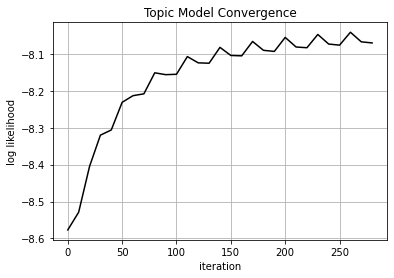

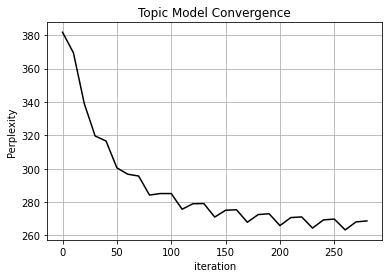

Note: Log likelihood is per-word ELBO
Note: Perplexity estimate based on a held-out corpus of 4 documents


In [27]:
p = re.compile(r"(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
matches = [p.findall(l) for l in open('gensim_lem.log')]
matches = [m for m in matches if len(m) > 0]
tuples = [t[0] for t in matches]
perplexity = [float(t[1]) for t in tuples]
liklihood = [float(t[0]) for t in tuples]
iter = list(range(0,len(tuples)*10,10))
plt.plot(iter[:-1],liklihood[:-1],c="black")
plt.ylabel("log likelihood")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
plt.show()


plt.plot(iter[:-1],perplexity[:-1],c="black")
plt.ylabel("Perplexity")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
plt.show()
print('Note: Log likelihood is per-word ELBO')
print('Note: Perplexity estimate based on a held-out corpus of 4 documents')


In [28]:
print('\nLog Likelihood(per-word ELBO): ', lda_model_lemmatized.log_perplexity(corpus_lemmatized))



Log Likelihood(per-word ELBO):  -8.056536944241937


In [29]:
coherence_model_lda_lemmatized = CoherenceModel(
   model=lda_model_lemmatized, texts=data_lemmatized_filtered, dictionary=id2word_lemmatized, coherence='c_v'
)
coherence_lda_lemmatized = coherence_model_lda_lemmatized.get_coherence()
print('\nCoherence Score: ', coherence_lda_lemmatized)




Coherence Score:  0.6403392583425338


# About how gensim reports perplexity
https://tedboy.github.io/nlps/_modules/gensim/models/ldamodel.html#LdaModel.log_perplexity

    They calculate the ELBO of the variational inferred q vs p in function "bound"
    
        def bound(self, corpus, gamma=None, subsample_ratio=1.0):
            Estimate the variational bound of documents from `corpus`:
            E_q[log p(corpus)] - E_q[log q(corpus)]
        
    Then they divide the ELBO by the number of words/tokens so that it is "per-word".
    The likelihood reported above is the per-word likelihood, and perplexity=2^(-bound)
        
        def log_perplexity(self, chunk, total_docs=None):
            Calculate and return per-word likelihood bound, using the `chunk` of
            documents as evaluation corpus. Also output the calculated statistics. incl.
            perplexity=2^(-bound), to log at INFO level.


## Finding the right value of K

In [30]:
K_Coherence={}
models={}

In [31]:

for K in [5,10,15,20,25,30,40]:
    print('Starting K={}'.format(K))
    starttime=time.time()
    setUpNewLogFile('gensim_lem_{}.log'.format(K))

    #New code uses multicore which runs works in parallel for each CPU core.
    lda_model_lemmatized = gensim.models.ldamulticore.LdaMulticore(
       corpus=corpus_lemmatized, id2word=id2word_lemmatized, num_topics=K, random_state=100, 
       eval_every=1000, chunksize=1000, passes=8, alpha='symmetric', per_word_topics=True
    )
    coherence_model_lda_lemmatized = CoherenceModel(
       model=lda_model_lemmatized, texts=data_lemmatized_filtered, dictionary=id2word_lemmatized, coherence='c_v'
    )
    coherence_lda_lemmatized = coherence_model_lda_lemmatized.get_coherence()
    print('Coherence Score: ', coherence_lda_lemmatized)
    K_Coherence[K]=coherence_lda_lemmatized
    print('Time taken = {:.0f} minutes'.format((time.time()-starttime)/60.0))
    models[K]=lda_model_lemmatized

Starting K=5
Coherence Score:  0.5389239567891656
Time taken = 4 minutes
Starting K=10
Coherence Score:  0.6099184296764066
Time taken = 4 minutes
Starting K=15
Coherence Score:  0.5973412754528363
Time taken = 5 minutes
Starting K=20
Coherence Score:  0.6388475318646645
Time taken = 6 minutes
Starting K=25
Coherence Score:  0.6338603118566203
Time taken = 5 minutes
Starting K=30
Coherence Score:  0.6058427293700973
Time taken = 5 minutes
Starting K=40
Coherence Score:  0.5885248948784766
Time taken = 7 minutes


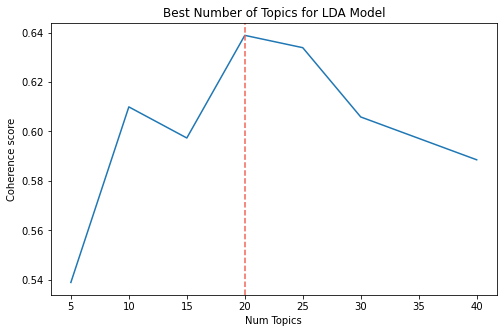

In [32]:
plt.figure(figsize=(8,5))

x = list(K_Coherence.keys())
coherence_values= list(K_Coherence.values())

# Build the line plot
#ax = sns.lineplot(x=x, y=coherence_values, color='#238C8C')
ax=plt.plot(x,coherence_values)

# Set titles and labels
plt.title("Best Number of Topics for LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

# Add a vertical line to show the optimum number of topics
plt.axvline(x[np.argmax(coherence_values)], 
            color='#F26457', linestyle='--')


# Exploring final model (with Lemmatization)

In [33]:
#Choose model with K=20
lda_model_lemmatized=models[20]

In [34]:
pprint(lda_model_lemmatized.print_topics())

[(0,
  '0.007*"displaystyle" + 0.006*"example" + 0.005*"cell" + 0.005*"function" + '
  '0.005*"language" + 0.004*"case" + 0.004*"term" + 0.004*"protein" + '
  '0.004*"result" + 0.004*"type"'),
 (1,
  '0.060*"film" + 0.011*"star" + 0.009*"series" + 0.008*"direct" + '
  '0.007*"character" + 0.006*"movie" + 0.005*"award" + 0.005*"role" + '
  '0.005*"kill" + 0.005*"production"'),
 (2,
  '0.027*"club" + 0.024*"season" + 0.017*"league" + 0.016*"match" + '
  '0.015*"championship" + 0.014*"final" + 0.013*"football" + 0.012*"game" + '
  '0.011*"player" + 0.010*"event"'),
 (3,
  '0.010*"design" + 0.009*"system" + 0.007*"power" + 0.006*"engine" + '
  '0.006*"model" + 0.006*"car" + 0.005*"produce" + 0.005*"vehicle" + '
  '0.004*"low" + 0.004*"production"'),
 (4,
  '0.025*"station" + 0.024*"line" + 0.023*"road" + 0.016*"route" + '
  '0.014*"railway" + 0.012*"north" + 0.010*"highway" + 0.010*"bridge" + '
  '0.009*"train" + 0.009*"county"'),
 (5,
  '0.028*"woman" + 0.017*"medical" + 0.017*"hospital" 

In [35]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_lemmatized, corpus_lemmatized, id2word_lemmatized)
vis

C:\Users\jorda\anaconda3\envs\WH\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9     -0.006837 -0.115526       1        1  9.491898
14    -0.028194  0.187062       2        1  6.778347
19    -0.028711  0.093711       3        1  5.981915
8      0.070857 -0.080861       4        1  5.917258
10    -0.031716 -0.074270       5        1  5.849321
0     -0.172642  0.072178       6        1  5.612308
18    -0.041481 -0.088860       7        1  5.520355
17    -0.174956 -0.030878       8        1  5.512657
2      0.255416 -0.072376       9        1  5.331927
3     -0.064516  0.163509      10        1  5.276541
7     -0.053953 -0.150210      11        1  5.273848
1      0.045875 -0.066601      12        1  4.854788
13    -0.035774 -0.063935      13        1  4.766883
12    -0.082660 -0.071887      14        1  4.625568
16     0.079021  0.080745      15        1  3.629651
15     0.248738 -0.049571      16        1  3.622092
11     0.005434  0.017406      17        1  3.503793
4      0.063134  0.202989      18        1  3.448171
6      0.068184  0.153628      19        1  2.758227
5     -0.115219 -0.106255      20        1  2.244452, topic_info=          Term          Freq         Total Category  logprob  loglift
993       film  21007.000000  21007.000000  Default  30.0000  30.0000
124     season  19037.000000  19037.000000  Default  29.0000  29.0000
621       game  18941.000000  18941.000000  Default  28.0000  28.0000
1512     album  11985.000000  11985.000000  Default  27.0000  27.0000
535       song  11641.000000  11641.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
798     center    507.634999   5960.774266  Topic20  -5.6790   1.3335
1884    mother    432.583078   4258.635204  Topic20  -5.8390   1.5098
1582  training    421.027132   3362.963520  Topic20  -5.8661   1.7188
1433      help    448.437545   6891.514453  Topic20  -5.8030   1.0644
10       cause    437.170575   5858.049204  Topic20  -5.8285   1.2015

[1751 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
16119     17  0.984533  abc_affiliate
10866      5  0.970770       abdicate
19985      5  0.956116     abdication
4516       1  0.053180       abortion
4516       4  0.002532       abortion
...      ...       ...            ...
9900      13  0.968873        zionist
11817      1  0.030150         zombie
11817      4  0.065326         zombie
11817     12  0.879389         zombie
11817     17  0.020100         zombie

[13078 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 15, 20, 9, 11, 1, 19, 18, 3, 4, 8, 2, 14, 13, 17, 16, 12, 5, 7, 6])

# Exploring underlying code

This code is obtained from the below by the GNU General Public License, and adapted and modified for use here.
Please see https://github.com/blei-lab/onlineldavb/blob/master/onlineldavb.py



In [36]:


# onlineldavb.py: Package of functions for fitting Latent Dirichlet
# Allocation (LDA) with online variational Bayes (VB).
#
# Copyright (C) 2010  Matthew D. Hoffman
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

import sys, re, time, string
import numpy as n
from scipy.special import gammaln, psi


n.random.seed(100000001)
meanchangethresh = 0.001


![LDA ALGO](https://github.com/duha-aldebakel/DSC180B-LDACode/blob/master/images/dirichlet_expectation.PNG?raw=true)



In [37]:
def dirichlet_expectation(alpha):
    """
    For a vector theta ~ Dir(alpha), computes E[log(theta)] given alpha.
    """
    if (len(alpha.shape) == 1):
        return(psi(alpha) - psi(n.sum(alpha)))
    return(psi(alpha) - psi(n.sum(alpha, 1))[:, n.newaxis])

In [38]:
dirichlet_expectation(np.array([-1,0,0.5,1.0,100]))

array([            nan,            -inf, -6.56868438e+00, -5.18239002e+00,
       -5.01249984e-03])

In [156]:

class OnlineLDA:
    """
    Implements online VB for LDA as described in (Hoffman et al. 2010).
    """

    def __init__(self, vocab, K, D, alpha, eta, tau0, kappa):
        """
        Arguments:
        K: Number of topics
        vocab: A set of words to recognize. When analyzing documents, any word
           not in this set will be ignored.
        D: Total number of documents in the population. For a fixed corpus,
           this is the size of the corpus. In the truly online setting, this
           can be an estimate of the maximum number of documents that
           could ever be seen.
        alpha: Hyperparameter for prior on weight vectors theta
        eta: Hyperparameter for prior on topics beta
        tau0: A (positive) learning parameter that downweights early iterations
        kappa: Learning rate: exponential decay rate---should be between
             (0.5, 1.0] to guarantee asymptotic convergence.
        Note that if you pass the same set of D documents in every time and
        set kappa=0 this class can also be used to do batch VB.
        """
        self._vocab = dict()
        for word in vocab:
            #This will be done in preprocessing.
            #word = word.lower()
            #word = re.sub(r'[^a-z]', '', word)
            self._vocab[word] = len(self._vocab)

        self._K = K
        self._W = len(self._vocab)
        self._D = D
        self._alpha = alpha
        self._eta = eta
        self._tau0 = tau0 + 1
        self._kappa = kappa
        self._updatect = 0

        # Initialize the variational distribution q(beta|lambda)
        self._lambda = 1*n.random.gamma(100., 1./100., (self._K, self._W))
        self._Elogbeta = dirichlet_expectation(self._lambda)
        self._expElogbeta = n.exp(self._Elogbeta)
        
        self.maxEIter = 100
        self.vocabLimit=self._W
        self.sortedByFrequencies=None

    def do_e_step(self, wordids, wordcts):
        """
        Given a mini-batch of documents, estimates the parameters
        gamma controlling the variational distribution over the topic
        weights for each document in the mini-batch.
        Arguments:
        docs:  List of D documents. Each document must be represented
               as a string. (Word order is unimportant.) Any
               words not in the vocabulary will be ignored.
        Returns a tuple containing the estimated values of gamma,
        as well as sufficient statistics needed to update lambda.
        """

        batchD = len(wordids)

        # Initialize the variational distribution q(theta|gamma) for
        # the mini-batch
        gamma = 1*n.random.gamma(100., 1./100., (batchD, self._K))
        Elogtheta = dirichlet_expectation(gamma)
        expElogtheta = n.exp(Elogtheta)

        sstats = n.zeros(self._lambda.shape)
        # Now, for each document d update that document's gamma and phi
        it = 0
        meanchange = 0
        for d in range(0, batchD):
            # print(sum(wordcts[d]))
            # These are mostly just shorthand (but might help cache locality)
            ids = wordids[d]
            cts = wordcts[d]
            gammad = gamma[d, :]
            Elogthetad = Elogtheta[d, :]
            expElogthetad = expElogtheta[d, :]
            expElogbetad = self._expElogbeta[:, ids]                              
            # The optimal phi_{dwk} is proportional to 
            # expElogthetad_k * expElogbetad_w. phinorm is the normalizer.
            phinorm = n.dot(expElogthetad, expElogbetad) + 1e-100
            # Iterate between gamma and phi until convergence
            for it in range(0, self.maxEIter):
                lastgamma = gammad
                # We represent phi implicitly to save memory and time.
                # Substituting the value of the optimal phi back into
                # the update for gamma gives this update. Cf. Lee&Seung 2001.
                gammad = self._alpha + expElogthetad * \
                    n.dot(cts / phinorm, expElogbetad.T)                          #<----E step gamma update
                

                #print(gammad[:, n.newaxis])
                Elogthetad = dirichlet_expectation(gammad)                        # we use gammad to calculate Elogthetad
                expElogthetad = n.exp(Elogthetad)
                phinorm = n.dot(expElogthetad, expElogbetad) + 1e-100             #<----E step phi update
                # If gamma hasn't changed much, we're done.
                meanchange = n.mean(abs(gammad - lastgamma))
                if (meanchange < meanchangethresh):                               #<----E step ends when gamma stop changing
                    break
            gamma[d, :] = gammad
            # Contribution of document d to the expected sufficient
            # statistics for the M step.
            sstats[:, ids] += n.outer(expElogthetad.T, cts/phinorm)               #lambda shape is (k,w)

        # This step finishes computing the sufficient statistics for the
        # M step, so that
        # sstats[k, w] = \sum_d n_{dw} * phi_{dwk} 
        # = \sum_d n_{dw} * exp{Elogtheta_{dk} + Elogbeta_{kw}} / phinorm_{dw}.
        sstats = sstats * self._expElogbeta

        return((gamma, sstats))


    def update_lambda(self, wordids, wordcts):
        """
        First does an E step on the mini-batch given in wordids and
        wordcts, then uses the result of that E step to update the
        variational parameter matrix lambda.
        Arguments:
        docs:  List of D documents. Each document must be represented
               as a string. (Word order is unimportant.) Any
               words not in the vocabulary will be ignored.
        Returns gamma, the parameters to the variational distribution
        over the topic weights theta for the documents analyzed in this
        update.
        Also returns an estimate of the variational bound for the
        entire corpus for the OLD setting of lambda based on the
        documents passed in. This can be used as a (possibly very
        noisy) estimate of held-out likelihood.
        """

        # rhot will be between 0 and 1, and says how much to weight
        # the information we got from this mini-batch.
        rhot = pow(self._tau0 + self._updatect, -self._kappa)
        self._rhot = rhot
        # Do an E step to update gamma, phi | lambda for this
        # mini-batch. This also returns the information about phi that
        # we need to update lambda.
        (gamma, sstats) = self.do_e_step(wordids, wordcts)
        # Estimate held-out likelihood for current values of lambda.
        # bound = self.approx_bound(wordids, wordcts, gamma)
        bound=0.0 # Avoid calculating to save time.
        # Update lambda based on documents.
        self._lambda = self._lambda * (1-rhot) + \
            rhot * (self._eta + self._D * sstats / len(wordids))               #<----M step. eta="n",
                                                                               #     sstats captures summand from estep but across documents      
            
        # Code to under parameterize the model to explore early stopping times
        if self.vocabLimit!=self._W:
            self._lambda[:,self.sortedByFrequencies[:max(1,self._W-self.vocabLimit)]]=self._eta
        
        
        self._Elogbeta = dirichlet_expectation(self._lambda)                   # we use lambda to calculate expElogbeta
        self._expElogbeta = n.exp(self._Elogbeta)
        self._updatect += 1

        return(gamma, bound)

    def approx_bound(self, wordids, wordcts, gamma):
        """
        Estimates the variational bound over *all documents* using only
        the documents passed in as "docs." gamma is the set of parameters
        to the variational distribution q(theta) corresponding to the
        set of documents passed in.
        The output of this function is going to be noisy, but can be
        useful for assessing convergence.
        """

        # This is to handle the case where someone just hands us a single
        # document, not in a list.
        batchD = len(wordids)

        score = 0
        Elogtheta = dirichlet_expectation(gamma)
        expElogtheta = n.exp(Elogtheta)

        # E[log p(docs | theta, beta)]
        for d in range(0, batchD):
            ids = wordids[d]
            cts = n.array(wordcts[d])
            phinorm = n.zeros(len(ids))
            for i in range(0, len(ids)):
                temp = Elogtheta[d, :] + self._Elogbeta[:, ids[i]]
                tmax = max(temp)
                phinorm[i] = n.log(sum(n.exp(temp - tmax))) + tmax
            score += n.sum(cts * phinorm)
#             oldphinorm = phinorm
#             phinorm = n.dot(expElogtheta[d, :], self._expElogbeta[:, ids])
#             score += n.sum(cts * n.log(phinorm))

        # E[log p(theta | alpha) - log q(theta | gamma)]
        score += n.sum((self._alpha - gamma)*Elogtheta)
        score += n.sum(gammaln(gamma) - gammaln(self._alpha))
        score += sum(gammaln(self._alpha*self._K) - gammaln(n.sum(gamma, 1)))

        # Compensate for the subsampling of the population of documents
        score = score * self._D / len(wordids)

        # E[log p(beta | eta) - log q (beta | lambda)]
        score = score + n.sum((self._eta-self._lambda)*self._Elogbeta)
        score = score + n.sum(gammaln(self._lambda) - gammaln(self._eta))
        score = score + n.sum(gammaln(self._eta*self._W) - 
                              gammaln(n.sum(self._lambda, 1)))

        return(score)





![LDA ALGO](https://github.com/duha-aldebakel/DSC180B-LDACode/blob/master/images/VB_LDA_annotate.png?raw=true)

![LDA ALGO](https://github.com/duha-aldebakel/DSC180B-LDACode/blob/master/images/VB_LDA_Algo1.PNG?raw=true)


What is the variational family q?

Blei and Hoffman uses a mean field variational inference to approximate p.

The variational family q assumes that β, θ, z are independent and can be fully factored.

$$q(β, θ, z) = \prod_{k} q(β_k) \prod_{d} q(θ_d) \prod_{n} q(z_{dn})$$

where 
(topic assignments)
$$q(z_{di} = k) = φ_{dwdik}     i.e. categorical$$        
(topic proportions)
$$q(θ_d) = Dirichlet(θ_d; γ_d) $$                         
(topics)
$$q(β_k) = Dirichlet(β_k; λ_k)$$                          

Note that the posterior p also has
$$ θ_d \sim Dirichlet(\alpha)$$
$$ z_{di} \sim Multinomial(θ)$$
and so the distributions are mirrored in q, but the big difference is the dependence of the terms (such as between θ and β) in p which make the calculation intractable.

![MFVB](https://github.com/duha-aldebakel/DSC180B-LDACode/blob/master/images/LDA_Meanfield.PNG?raw=true)

# Optimizing maxE Iter

In [161]:
from collections import defaultdict
eLoopTime=defaultdict(list, {5: [36, 58, 35, 30, 51, 47], 10: [35, 47, 43, 51, 55, 59], 20: [95, 68, 93, 75, 84, 81], 40: [84, 55, 86, 66, 103, 54], 80: [111, 50, 64, 63, 59, 85]})
eLoopBound=defaultdict(list, {5: [-111733851.43260013, -117781528.69408886, -123040409.73264208, -128633409.69968084, -121205953.4537439, -110966698.16985334], 10: [-129755490.7799989, -128921847.34090501, -117951450.05467737, -120393444.00248368, -120385338.58080256, -108159118.92671846], 20: [-124170809.46135023, -136015016.3987571, -106827136.22064555, -115562658.78387602, -124336169.61204082, -118594594.42351212], 40: [-114759190.73191096, -132424958.91197848, -133231030.76268373, -111836848.71508917, -131526004.52976249, -117476012.67518403], 80: [-117973922.65220611, -146022696.2883227, -117976902.21794659, -133024236.67739585, -120428154.47847381, -119522519.74053846]})



In [160]:
from datetime import datetime
import random

K=20
datasetsize=25
sortedByFrequencies=sorted([t for t,f in id2word_lemmatized.cfs.items()],reverse=True)


for maxE in [5,10,20,40,80]:
    random.shuffle(corpus_lemmatized)
    if True:
        start=datetime.now()
        
        D = 100000 #estimate of number of documents in the population
        S = 1000 #sample size of a batch
        alpha = 0.1
        eta = 0.01
        
        tau0 = 10.0
        kappa = 0.05


        '''
            Hyperparameter of Dirichlet priors
                concentration parameter of Dirichlet prior, which smaller meaning more concentrated
                we like it to be relatively concentrated since any topic usually uses a small number of key words
                we allow one document to have more than one topic, but we want to penalize it when there are too many potential topics

            alpha: Hyperparameter for prior on weight vectors theta
            eta: Hyperparameter for prior on topics beta

            Learning rate parameters:
            tau0: A (positive) learning parameter that downweights early iterations
            kappa: Learning rate: exponential decay rate---should be between
                 (0.5, 1.0] to guarantee asymptotic convergence.


            For each document d, we would like to know the distributions of 
                theta, the topic distribution of the document
                z_n, the topic of n-th word in document
                (so for each document, there is one theta and N z_n)

            but we only observe
                w_n, the actual n-th word in document


        '''

        vocab=list(id2word_lemmatized.token2id.keys())
        model = OnlineLDA(vocab, K, D, alpha, eta, tau0, kappa)

        model.maxEIter=maxE
        
        
        bounds=[]
        bounds_h=[]
        times=[]
        lasttime=0
        for i in range(1000):
            j=i%datasetsize #We only have 50k documents, so we make another pass after 50
            batch=corpus_lemmatized[(j*S):((j+1)*S)]
            wordids = [[w for w,c in doc] for doc in batch]
            wordcts = [[c for w,c in doc] for doc in batch]
            if i==0:
                holdids=wordids #First batch is the holdout
                holdcts=wordcts #First batch is the holdout
            if j==0:
                continue #Don't use holdout for learning

            (gamma, bound)=model.update_lambda(wordids, wordcts)
            (gamma_h, sstats_h) = model.do_e_step(holdids, holdcts)
            # Estimate held-out likelihood for current values of lambda.
            
            earlystoppingtime=(datetime.now()-start).seconds
            if earlystoppingtime<max(lasttime*1.1,lasttime+5):
                continue
                
            lasttime=earlystoppingtime
            bound_h = model.approx_bound(holdids, holdcts, gamma_h)
            #bound is the evidence lower bound (ELBO)
            
            print('elasped {}s bound_h {}'.format(earlystoppingtime,bound_h))
            
            bounds.append(bound)
            bounds_h.append(bound_h)
            times.append(earlystoppingtime)

            if len(bounds_h)>3:
                if bounds_h[-1]*(1+10**-5) < bounds_h[-3]*0.5+bounds_h[-2]*0.5:
                    break
        eLoopTime[maxE].append(times[-1])
        eLoopBound[maxE].append(bound_h)
        print(eLoopTime)
        print(eLoopBound)


elasped 5s bound_h -136267826.18031698
elasped 10s bound_h -128263930.42697008
elasped 15s bound_h -125744360.13373388
elasped 20s bound_h -123689691.37342621
elasped 25s bound_h -122203664.65412
elasped 30s bound_h -122528927.37341288
elasped 35s bound_h -123040409.73264208
defaultdict(<class 'list'>, {5: [36, 58, 35], 10: [35, 47], 20: [95, 68], 40: [84, 55], 80: [111, 50]})
defaultdict(<class 'list'>, {5: [-111733851.43260013, -117781528.69408886, -123040409.73264208], 10: [-129755490.7799989, -128921847.34090501], 20: [-124170809.46135023, -136015016.3987571], 40: [-114759190.73191096, -132424958.91197848], 80: [-117973922.65220611, -146022696.2883227]})
elasped 6s bound_h -135973829.26449877
elasped 11s bound_h -128091399.56428455
elasped 17s bound_h -120703894.0639299
elasped 23s bound_h -119836331.55320163
elasped 28s bound_h -118250400.0311478
elasped 33s bound_h -118202014.87762487
elasped 38s bound_h -117484910.82584776
elasped 43s bound_h -117951450.05467737
defaultdict(<cla

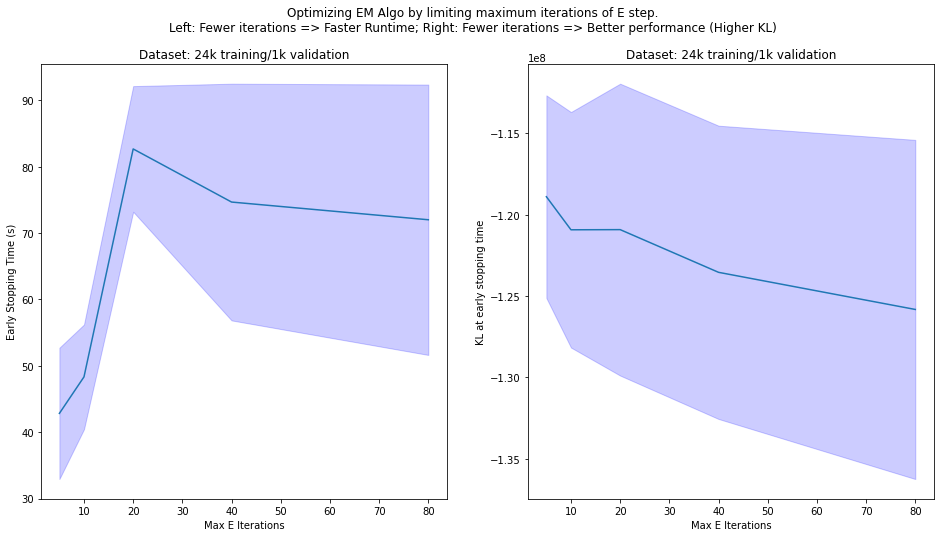

In [173]:
#optimalStopping1=defaultdict(list, {(49, 1000): [28, 26, 25, 25, 37, 24, 23], (49, 2500): [25, 22, 27, 25, 25, 25, 24], (49, 5000): [72, 33, 39, 21, 47, 54, 31], (49, 7500): [141, 56, 46, 79, 47, 65, 56], (49, 10000): [90, 69, 69, 102, 42, 53, 52], (49, 12500): [79, 129, 66, 132, 50, 53, 67], (49, 17500): [85, 72, 108, 199, 74, 74, 64], (49, 25000): [46, 46, 132, 177, 36, 72, 40], (24, 1000): [28, 25, 23, 26, 26], (24, 2500): [25, 21, 27, 23, 25], (24, 5000): [28, 55, 50, 49, 41], (24, 7500): [58, 58, 52, 44, 90], (24, 10000): [145, 86, 70, 57, 95], (24, 12500): [116, 44, 57, 61, 87], (24, 17500): [105, 41, 59, 51, 92], (24, 25000): [51, 38, 55, 57, 34]})
#bounds1=defaultdict(list, {(49, 1000): [-998194257.1642556, -1095456596.5818567, -1100399814.201931, -1029909183.6608187, -981458399.0885481, -903910300.5293587, -1102162092.206788], (49, 2500): [-665666849.5067981, -719763935.5247184, -731620668.4432298, -687558590.6330025, -660973095.7090081, -610420930.4534196, -732937523.7922016], (49, 5000): [-419607059.683642, -463499888.2883105, -473984839.6912091, -440411852.15347314, -421756218.6912478, -390860733.83558583, -468692155.3741295], (49, 7500): [-313451185.1621156, -349914160.78807825, -351496716.5601026, -332178324.4986993, -316071073.5553272, -296508916.5365056, -348425071.7020502], (49, 10000): [-253381669.23777437, -285237898.90167546, -283415976.6579154, -268567647.7925903, -257398119.96651784, -241925088.44060424, -280337975.1363392], (49, 12500): [-211749383.31563538, -233941880.14547443, -236564246.26498532, -218724536.15935552, -215864683.01407605, -198976275.66862857, -234468706.36694112], (49, 17500): [-162998427.6197213, -178125247.19979393, -177715543.5462643, -166037349.51466078, -163864490.63850206, -151177561.37048876, -176701850.46905833], (49, 25000): [-126141984.68494612, -137410075.78219366, -135109696.92980337, -125637042.01938434, -125286014.70316769, -111500899.45368625, -136662757.282798], (24, 1000): [-1047066521.4891374, -1059318107.2972255, -1024938520.6206334, -998660237.2699218, -1198712524.0377142], (24, 2500): [-697684131.9923387, -703759891.2825785, -682433386.3950112, -664655460.4390564, -804248851.5550691], (24, 5000): [-440641225.11394835, -453375292.97163594, -430877066.301605, -422867628.36608446, -510132046.03787166], (24, 7500): [-329768828.97523427, -338553341.50162375, -323980951.425455, -314746492.4067762, -382080818.2538295], (24, 10000): [-266600154.60551196, -277629977.1691631, -264050733.03423578, -254567834.32425457, -306177025.3186517], (24, 12500): [-220844219.1138323, -232119375.94622564, -219311156.71592197, -215279404.10681581, -258861056.79998392], (24, 17500): [-170668967.8835243, -177887764.41272148, -167916057.5947904, -162417430.3290679, -195874373.98034608], (24, 25000): [-131545198.24238288, -135639750.5600292, -127297022.74252202, -123486080.1220711, -152052717.99319363]})

import numpy as np;
import pandas as pd
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2,figsize=(16,8))
fig.suptitle('Optimizing EM Algo by limiting maximum iterations of E step.\nLeft: Fewer iterations => Faster Runtime; Right: Fewer iterations => Better performance (Higher KL)')


f=0
if True:
    x=[5,10,20,40,80]
    y=[]
    ymax=[]
    ymin=[]
    for maxE in x:
        tme = eLoopTime[maxE]
        y.append(np.mean(tme))
        ymax.append(np.mean(tme)+np.std(tme))
        ymin.append(np.mean(tme)-np.std(tme))
    axs[f].plot(x,y)
    axs[f].set_xlabel('Max E Iterations')
    axs[f].set_ylabel('Early Stopping Time (s)')
    axs[f].fill_between(x, ymax, ymin, color='blue', alpha=0.2, label='1 S.D.')
    axs[f].title.set_text('Dataset: {}k training/1k validation'.format(datasetsize-1))
    f+=1

    
if True:
    x=[5,10,20,40,80]
    y=[]
    ymax=[]
    ymin=[]
    for maxE in x:
        tme = eLoopBound[maxE]
        y.append(np.mean(tme))
        ymax.append(np.mean(tme)+np.std(tme))
        ymin.append(np.mean(tme)-np.std(tme))
    axs[f].plot(x,y)
    axs[f].set_xlabel('Max E Iterations')
    axs[f].set_ylabel('KL at early stopping time')
    axs[f].fill_between(x, ymax, ymin, color='blue', alpha=0.2, label='1 S.D.')
    axs[f].title.set_text('Dataset: {}k training/1k validation'.format(datasetsize-1))
    f+=1
plt.savefig('OptimalMaxE.png')
plt.show()    

# Early Stopping

In [53]:
from datetime import datetime
import random
from collections import defaultdict

len(corpus_lemmatized)
optimalStopping=defaultdict(list)
boundsh=defaultdict(list)



In [79]:
sortedByFrequencies=sorted([t for t,f in id2word_lemmatized.cfs.items()],reverse=True)

for iter in range(5):
    maxE=20
    K=20
    datasetsize=25
    random.shuffle(corpus_lemmatized)
    for vocabLimit in [1000,2500,5000,7500,10000,12500,17500,25000]:
        start=datetime.now()
        print('datasetsize = {}k, vocabLimit = {}'.format(datasetsize-1,vocabLimit))
        
        D = 100000 #estimate of number of documents in the population
        S = 1000 #sample size of a batch
        alpha = 0.1
        eta = 0.01
        
        tau0 = 10.0
        kappa = 0.05


        '''
            Hyperparameter of Dirichlet priors
                concentration parameter of Dirichlet prior, which smaller meaning more concentrated
                we like it to be relatively concentrated since any topic usually uses a small number of key words
                we allow one document to have more than one topic, but we want to penalize it when there are too many potential topics

            alpha: Hyperparameter for prior on weight vectors theta
            eta: Hyperparameter for prior on topics beta

            Learning rate parameters:
            tau0: A (positive) learning parameter that downweights early iterations
            kappa: Learning rate: exponential decay rate---should be between
                 (0.5, 1.0] to guarantee asymptotic convergence.


            For each document d, we would like to know the distributions of 
                theta, the topic distribution of the document
                z_n, the topic of n-th word in document
                (so for each document, there is one theta and N z_n)

            but we only observe
                w_n, the actual n-th word in document


        '''

        vocab=list(id2word_lemmatized.token2id.keys())
        model = OnlineLDA(vocab, K, D, alpha, eta, tau0, kappa)

        model.maxEIter=maxE
        model.vocabLimit=vocabLimit
        model.sortedByFrequencies=sortedByFrequencies
        
        bounds=[]
        bounds_h=[]
        times=[]
        lasttime=0
        for i in range(1000):
            j=i%datasetsize #We only have 50k documents, so we make another pass after 50
            batch=corpus_lemmatized[(j*S):((j+1)*S)]
            wordids = [[w for w,c in doc] for doc in batch]
            wordcts = [[c for w,c in doc] for doc in batch]
            if i==0:
                holdids=wordids #First batch is the holdout
                holdcts=wordcts #First batch is the holdout
            if j==0:
                continue #Don't use holdout for learning

            (gamma, bound)=model.update_lambda(wordids, wordcts)
            (gamma_h, sstats_h) = model.do_e_step(holdids, holdcts)
            # Estimate held-out likelihood for current values of lambda.
            
            earlystoppingtime=(datetime.now()-start).seconds
            if earlystoppingtime<max(lasttime*1.1,lasttime+5):
                continue
                
            lasttime=earlystoppingtime
            bound_h = model.approx_bound(holdids, holdcts, gamma_h)
            #bound is the evidence lower bound (ELBO)
            
            print('elasped {}s bound_h {}'.format(earlystoppingtime,bound_h))
            
            bounds.append(bound)
            bounds_h.append(bound_h)
            times.append(earlystoppingtime)

            if len(bounds_h)>3:
                if bounds_h[-1]*(1+10**-5) < bounds_h[-3]*0.5+bounds_h[-2]*0.5:
                    break
        optimalStopping[(datasetsize-1,vocabLimit)].append(times[-1])
        boundsh[(datasetsize-1,vocabLimit)].append(bound_h)
        print(optimalStopping)
        print(boundsh)


datasetsize = 24k, vocabLimit = 1000
elasped 5s bound_h -1111933445.6659913
elasped 11s bound_h -1105228044.9330966
elasped 17s bound_h -1122774945.6781533
elasped 23s bound_h -1121020661.9411914
defaultdict(<class 'list'>, {(49, 1000): [28, 26, 25, 25, 37, 24, 23, 25, 25, 22, 24, 29, 25, 26, 25, 25, 25], (49, 2500): [25, 22, 27, 25, 25, 25, 24, 24, 26, 24, 37, 31, 24, 25, 26, 37, 33], (49, 5000): [72, 33, 39, 21, 47, 54, 31, 49, 41, 27, 60, 56, 36, 43, 58, 50, 54], (49, 7500): [141, 56, 46, 79, 47, 65, 56, 59, 45, 52, 80, 93, 36, 44, 64, 74, 60], (49, 10000): [90, 69, 69, 102, 42, 53, 52, 80, 83, 44, 64, 66, 35, 63, 104, 76, 72], (49, 12500): [79, 129, 66, 132, 50, 53, 67, 42, 82, 47, 69, 109, 35, 81, 86, 67, 54], (49, 17500): [85, 72, 108, 199, 74, 74, 64, 133, 82, 59, 70, 71, 30, 54, 78, 51, 36], (49, 25000): [46, 46, 132, 177, 36, 72, 40, 45, 77, 41, 38, 70, 29, 88, 82, 49, 73], (24, 1000): [28, 25, 23, 26, 26, 27, 24, 32, 26, 25, 23], (24, 2500): [25, 21, 27, 23, 25, 21, 25, 22, 3

In [134]:
tme

array([-1084.91502193, -1181.82899812, -1162.04402661, -1080.57213891,
       -1077.55304254,  -958.9907839 , -1175.4015024 , -1271.97913763,
       -1158.08233481, -1138.2107876 , -1071.24106614, -1244.10144361,
       -1090.00108296, -1012.30907593, -1213.44051432, -1104.59919251,
       -1104.70270874])

In [130]:
optimalStopping1=defaultdict(list, {(49, 1000): [28, 26, 25, 25, 37, 24, 23, 25, 25, 22, 24, 29, 25, 26, 25, 25, 25], (49, 2500): [25, 22, 27, 25, 25, 25, 24, 24, 26, 24, 37, 31, 24, 25, 26, 37, 33], (49, 5000): [72, 33, 39, 21, 47, 54, 31, 49, 41, 27, 60, 56, 36, 43, 58, 50, 54], (49, 7500): [141, 56, 46, 79, 47, 65, 56, 59, 45, 52, 80, 93, 36, 44, 64, 74, 60], (49, 10000): [90, 69, 69, 102, 42, 53, 52, 80, 83, 44, 64, 66, 35, 63, 104, 76, 72], (49, 12500): [79, 129, 66, 132, 50, 53, 67, 42, 82, 47, 69, 109, 35, 81, 86, 67, 54], (49, 17500): [85, 72, 108, 199, 74, 74, 64, 133, 82, 59, 70, 71, 30, 54, 78, 51, 36], (49, 25000): [46, 46, 132, 177, 36, 72, 40, 45, 77, 41, 38, 70, 29, 88, 82, 49, 73], (24, 1000): [28, 25, 23, 26, 26, 27, 24, 32, 26, 25, 23, 23, 26, 23, 25], (24, 2500): [25, 21, 27, 23, 25, 21, 25, 22, 32, 35, 24, 24, 24, 25, 26], (24, 5000): [28, 55, 50, 49, 41, 49, 66, 45, 47, 59, 60, 25, 50, 60, 81], (24, 7500): [58, 58, 52, 44, 90, 51, 86, 54, 61, 72, 53, 60, 50, 40, 44], (24, 10000): [145, 86, 70, 57, 95, 70, 45, 70, 58, 72, 47, 54, 48, 38, 43], (24, 12500): [116, 44, 57, 61, 87, 25, 49, 43, 59, 71, 51, 53, 49, 39, 44], (24, 17500): [105, 41, 59, 51, 92, 31, 46, 40, 53, 77, 66, 47, 58, 41, 62], (24, 25000): [51, 38, 55, 57, 34, 77, 39, 58, 53, 72, 29, 47, 58, 46, 54]})

bounds1=defaultdict(list, {(49, 1000): [-998194257.1642556, -1095456596.5818567, -1100399814.201931, -1029909183.6608187, -981458399.0885481, -903910300.5293587, -1102162092.206788, -1160587733.754655, -1076599139.8808436, -1052261098.9517512, -965457916.9812279, -1178935419.4247515, -983501853.5741019, -957531625.9612143, -1154346182.9332714, -1051951686.1734123, -1042566358.6474695], (49, 2500): [-665666849.5067981, -719763935.5247184, -731620668.4432298, -687558590.6330025, -660973095.7090081, -610420930.4534196, -732937523.7922016, -771285165.208796, -718297372.605426, -697108066.6748937, -648831843.7096227, -780586681.9069722, -655100105.8054186, -634984758.5380279, -763871978.9166223, -696454849.883379, -701043744.7646774], (49, 5000): [-419607059.683642, -463499888.2883105, -473984839.6912091, -440411852.15347314, -421756218.6912478, -390860733.83558583, -468692155.3741295, -491188625.6306342, -458904364.01091343, -445412888.61543417, -415679633.00668335, -492610164.0775696, -412043615.76608914, -406004812.70485824, -487688760.8212802, -436378845.7280582, -444174653.8210267], (49, 7500): [-313451185.1621156, -349914160.78807825, -351496716.5601026, -332178324.4986993, -316071073.5553272, -296508916.5365056, -348425071.7020502, -369345602.9117049, -339886507.53309107, -332348100.6626431, -309702249.5684491, -371624796.26009846, -312266309.63001275, -305929642.5539094, -365674875.44325906, -325919534.52877593, -337395362.397448], (49, 10000): [-253381669.23777437, -285237898.90167546, -283415976.6579154, -268567647.7925903, -257398119.96651784, -241925088.44060424, -280337975.1363392, -301295905.7234639, -276085824.5329142, -271390287.6143202, -250078172.756984, -303820706.0139278, -254351714.33578593, -248589584.49695164, -289296695.8771434, -263713816.98898664, -270059938.5039426], (49, 12500): [-211749383.31563538, -233941880.14547443, -236564246.26498532, -218724536.15935552, -215864683.01407605, -198976275.66862857, -234468706.36694112, -251486438.45349512, -229160364.69251543, -224620662.0907861, -206789141.50793588, -249526378.8686759, -212679117.04648873, -207966048.18771276, -241961178.56764787, -220177375.5761717, -225920026.50175297], (49, 17500): [-162998427.6197213, -178125247.19979393, -177715543.5462643, -166037349.51466078, -163864490.63850206, -151177561.37048876, -176701850.46905833, -189896192.326605, -177425273.61541587, -173379475.35801092, -158401218.56620368, -189789317.10052794, -163971285.34937516, -158279688.83073252, -186105854.2457284, -166498616.96744147, -171464885.08538607], (49, 25000): [-126141984.68494612, -137410075.78219366, -135109696.92980337, -125637042.01938434, -125286014.70316769, -111500899.45368625, -136662757.282798, -147891742.35339248, -134649074.98596144, -132338630.06352834, -124552127.51944591, -144650430.74723792, -126733335.91443872, -117700163.949119, -141085515.15995526, -128430643.51340666, -128442679.24244544], (24, 1000): [-1047066521.4891374, -1059318107.2972255, -1024938520.6206334, -998660237.2699218, -1198712524.0377142, -1107968994.6102257, -1104506349.8645756, -1110338255.154797, -1086691525.8411527, -1063666118.3785359, -1121020661.9411914, -845643713.9893353, -912724713.607294, -1118647747.4985409, -899014079.219428], (24, 2500): [-697684131.9923387, -703759891.2825785, -682433386.3950112, -664655460.4390564, -804248851.5550691, -740584950.3790542, -731378554.024375, -739477885.6184146, -714687859.7371073, -707708467.4264687, -743717869.982882, -562371163.632134, -602675871.6333851, -744016095.659933, -588504587.7055827], (24, 5000): [-440641225.11394835, -453375292.97163594, -430877066.301605, -422867628.36608446, -510132046.03787166, -477394955.6432093, -467215423.23562133, -467476332.3972254, -449765594.06091523, -448622603.96225774, -473515478.15989137, -360241910.49731207, -385159273.4273931, -473489990.64110124, -374986746.9407623], (24, 7500): [-329768828.97523427, -338553341.50162375, -323980951.425455, -314746492.4067762, -382080818.2538295, -357047119.93239385, -349111593.83200455, -346282613.04021156, -335998421.39793164, -333720962.020499, -354098447.3315033, -267154225.98448005, -286271603.64892244, -354180680.81384873, -280735346.3965794], (24, 10000): [-266600154.60551196, -277629977.1691631, -264050733.03423578, -254567834.32425457, -306177025.3186517, -287430282.26566494, -286093042.91402787, -282482138.00835085, -275373499.4667418, -270484258.4033147, -288183392.00244355, -216449055.86220437, -232702158.09410918, -290010388.8424674, -224145421.8592903], (24, 12500): [-220844219.1138323, -232119375.94622564, -219311156.71592197, -215279404.10681581, -258861056.79998392, -242678820.80102357, -238287919.62213922, -234594702.08580625, -229999137.1203363, -223472905.47065973, -241847153.19285616, -179516188.3219154, -196278629.22855037, -240791551.1396017, -187618060.23319], (24, 17500): [-170668967.8835243, -177887764.41272148, -167916057.5947904, -162417430.3290679, -195874373.98034608, -187505487.17821977, -180496769.2415821, -181737548.58934164, -177084292.20328188, -170949271.90446287, -181906204.33242133, -138578763.1543834, -149930727.04111335, -185164406.9122162, -143591308.21863854], (24, 25000): [-131545198.24238288, -135639750.5600292, -127297022.74252202, -123486080.1220711, -152052717.99319363, -137007353.44156647, -139425005.087248, -139504405.07370424, -134848642.08073807, -130994306.74371827, -141117136.9485854, -106709795.82281478, -113963833.69288188, -141325590.49992764, -111421638.9808976]})



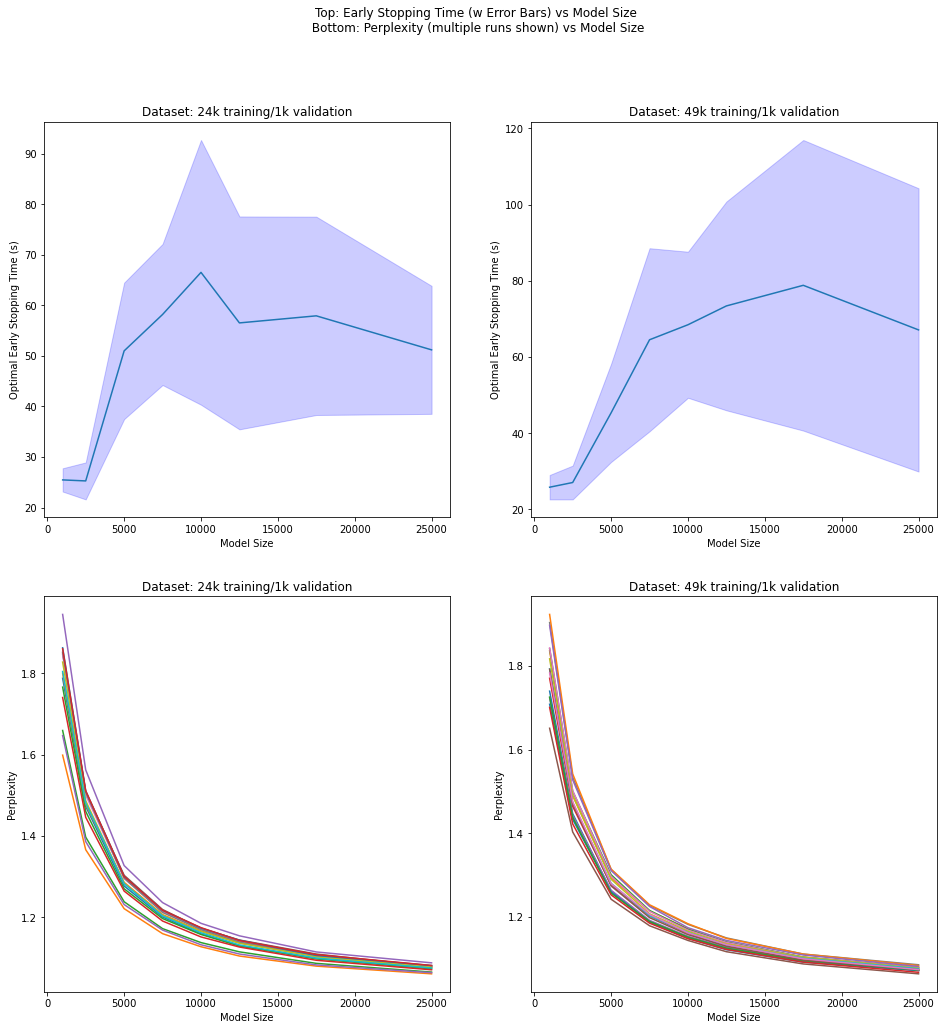

In [174]:
#optimalStopping1=defaultdict(list, {(49, 1000): [28, 26, 25, 25, 37, 24, 23], (49, 2500): [25, 22, 27, 25, 25, 25, 24], (49, 5000): [72, 33, 39, 21, 47, 54, 31], (49, 7500): [141, 56, 46, 79, 47, 65, 56], (49, 10000): [90, 69, 69, 102, 42, 53, 52], (49, 12500): [79, 129, 66, 132, 50, 53, 67], (49, 17500): [85, 72, 108, 199, 74, 74, 64], (49, 25000): [46, 46, 132, 177, 36, 72, 40], (24, 1000): [28, 25, 23, 26, 26], (24, 2500): [25, 21, 27, 23, 25], (24, 5000): [28, 55, 50, 49, 41], (24, 7500): [58, 58, 52, 44, 90], (24, 10000): [145, 86, 70, 57, 95], (24, 12500): [116, 44, 57, 61, 87], (24, 17500): [105, 41, 59, 51, 92], (24, 25000): [51, 38, 55, 57, 34]})
#bounds1=defaultdict(list, {(49, 1000): [-998194257.1642556, -1095456596.5818567, -1100399814.201931, -1029909183.6608187, -981458399.0885481, -903910300.5293587, -1102162092.206788], (49, 2500): [-665666849.5067981, -719763935.5247184, -731620668.4432298, -687558590.6330025, -660973095.7090081, -610420930.4534196, -732937523.7922016], (49, 5000): [-419607059.683642, -463499888.2883105, -473984839.6912091, -440411852.15347314, -421756218.6912478, -390860733.83558583, -468692155.3741295], (49, 7500): [-313451185.1621156, -349914160.78807825, -351496716.5601026, -332178324.4986993, -316071073.5553272, -296508916.5365056, -348425071.7020502], (49, 10000): [-253381669.23777437, -285237898.90167546, -283415976.6579154, -268567647.7925903, -257398119.96651784, -241925088.44060424, -280337975.1363392], (49, 12500): [-211749383.31563538, -233941880.14547443, -236564246.26498532, -218724536.15935552, -215864683.01407605, -198976275.66862857, -234468706.36694112], (49, 17500): [-162998427.6197213, -178125247.19979393, -177715543.5462643, -166037349.51466078, -163864490.63850206, -151177561.37048876, -176701850.46905833], (49, 25000): [-126141984.68494612, -137410075.78219366, -135109696.92980337, -125637042.01938434, -125286014.70316769, -111500899.45368625, -136662757.282798], (24, 1000): [-1047066521.4891374, -1059318107.2972255, -1024938520.6206334, -998660237.2699218, -1198712524.0377142], (24, 2500): [-697684131.9923387, -703759891.2825785, -682433386.3950112, -664655460.4390564, -804248851.5550691], (24, 5000): [-440641225.11394835, -453375292.97163594, -430877066.301605, -422867628.36608446, -510132046.03787166], (24, 7500): [-329768828.97523427, -338553341.50162375, -323980951.425455, -314746492.4067762, -382080818.2538295], (24, 10000): [-266600154.60551196, -277629977.1691631, -264050733.03423578, -254567834.32425457, -306177025.3186517], (24, 12500): [-220844219.1138323, -232119375.94622564, -219311156.71592197, -215279404.10681581, -258861056.79998392], (24, 17500): [-170668967.8835243, -177887764.41272148, -167916057.5947904, -162417430.3290679, -195874373.98034608], (24, 25000): [-131545198.24238288, -135639750.5600292, -127297022.74252202, -123486080.1220711, -152052717.99319363]})

import numpy as np;
import pandas as pd
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2,figsize=(16,16))
fig.suptitle('Top: Early Stopping Time (w Error Bars) vs Model Size\n Bottom: Perplexity (multiple runs shown) vs Model Size')

f=0
for datasetsize in [25,50]:
    x=[1000,2500,5000,7500,10000,12500,17500,25000]
    y=[]
    ymax=[]
    ymin=[]
    for vocabLimit in x:
        tme = optimalStopping1[(datasetsize-1,vocabLimit)]
        y.append(np.mean(tme))
        ymax.append(np.mean(tme)+np.std(tme))
        ymin.append(np.mean(tme)-np.std(tme))
    axs[0][f].plot(x,y)
    axs[0][f].set_xlabel('Model Size')
    axs[0][f].set_ylabel('Optimal Early Stopping Time (s)')
    axs[0][f].fill_between(x, ymax, ymin, color='blue', alpha=0.2, label='1 S.D.')
    axs[0][f].title.set_text('Dataset: {}k training/1k validation'.format(datasetsize-1))
    f+=1

    
f=0    
for datasetsize in [25,50]:
    x=[1000,2500,5000,7500,10000,12500,17500,25000]
    y=[]
    for vocabLimit in x:
        tme = bounds1[(datasetsize-1,vocabLimit)]
        tme= 2**-(0.0001*np.array(tme)/sum([sum(x) for x in holdcts]))
        y.append(tme)
    axs[1][f].plot(x,y)
    axs[1][f].set_xlabel('Model Size')
    axs[1][f].set_ylabel('Perplexity')
    axs[1][f].title.set_text('Dataset: {}k training/1k validation'.format(datasetsize-1))
    f+=1
plt.savefig('UnderInformativeEarlyStopping.png')
plt.show()    

In [ ]:
plt.plot(range(len(bounds_h)),bounds_h)
plt.title('ELBO on holdout set of 1k documents')

In [ ]:
perword_bounds_h=[0.01*y/sum([sum(x) for x in holdcts]) for y in bounds_h]
plt.plot(range(len(perword_bounds_h)),perword_bounds_h)
plt.title('Per-word likelihood on holdout set of 1k documents')

In [ ]:
perplexity=[2**(-y) for y in perword_bounds_h]
plt.plot(range(len(perplexity)),perplexity)
plt.title('Per-word likelihood on holdout set of 1k documents')